In [1]:
import pypsa
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RUN = "20231025-zecm"

In [3]:

matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
config_fn = "../../config/config.yaml"

plt.style.use(["bmh", matplotlibrc_fn])

with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]

# for EU: https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_aind__custom_9900786/default/table?lang=en
EUR_2015_TO_2020 = (1.002*1.017*1.019*1.015*1.007)
EUR_2015_TO_2020

1.0613493817548298

In [182]:
NICE_NAMES = {
    "import pipeline-h2": "hydrogen import (pipeline)",
    "import shipping-lh2": "hydrogen import (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch import",
    "import shipping-meoh": "methanol import",
    "import shipping-lch4": "methane import",
    "import shipping-lnh3": "ammonia import",
    "import shipping-steel": "steel import",
    "co2 stored": "carbon sequestration",
    "NH3": "ammonia demand",
    "gas": "fossil gas",
    "AC": "transmission losses",
    "DC": "transmission losses",
    "H2 pipeline": "transmission losses",
    "gas pipeline": "transmission losses",
    "ror": "run-of-river",
    "PHS": "pumped-hydro storage",
    "onwind": "onshore wind",
    "offwind-dc": "offshore wind",
    "offwind-ac": "offshore wind",
}

def rename(s):
    if s in NICE_NAMES:
        return NICE_NAMES[s]
    if "methanol emissions" in s:
        return "methanol emissions"
    if "oil emissions" in s:
        return "oil emissions"
    # if "gas CHP CC" in s:
    #     return "gas CHP CC"
    if "gas CHP" in s:
        return "gas CHP"
    # if "biomass CHP CC" in s:
    #     return "biomass CHP CC"
    if "biomass CHP" in s:
        return "biomass CHP"
    if "gas boiler" in s:
        return "gas boiler"
    if "biomass boiler" in s:
        return "biomass boiler"
    if "resistive heater" in s:
        return "resistive heater"
    if "heat pump" in s:
        return "heat pump"
    if "external" in s or "import hvdc-to-elec" in s:
        return "electricity imports"
    if "battery" in s:
        return "battery"
    if "electricity" in s:
        return "electricity demand"
    if "solar" in s:
        return "solar"
    if "water tanks" in s:
        return "hot water storage"
    return s

In [162]:
scenarios_fn = {
 "all imports allowed": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc",
 "only hydrogen imports": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H2_2050.nc",
 "no imports allowed": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc",
}

ebs = {}
for scenario, fn in scenarios_fn.items():
    n = pypsa.Network(fn)
    n.buses_t.marginal_price *= EUR_2015_TO_2020
    n.lines["capital_cost"] *= EUR_2015_TO_2020
    for c in n.iterate_components({"Generator", "Store", "Link", "StorageUnit"}):
        c.df.marginal_cost *= EUR_2015_TO_2020
    ebs[scenario] = n.statistics.energy_balance(nice_names=False).div(1e6).round(1)
ebs = pd.concat(ebs)
ebs.replace(0.0, np.nan, inplace=True)

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H2_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [183]:
carrier_xlabels = {
    "co2": r"withdrawal $\leftarrow$ Mt$_{CO_2}$ $\rightarrow$ emission      ",
    "co2 stored": r"consumption $\leftarrow$ Mt$_{CO_2}$ $\rightarrow$ supply       ",
    "H2": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "gas": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "methanol": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "oil": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "NH3": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "electricity": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
    "heat": r"consumption $\leftarrow$ TWh $\rightarrow$ supply          ",
}

carrier_nice_names = {
    "co2": "CO$_2$ atmosphere balance",
    "co2 stored": "CO$_2$ storage balance",
    "H2": "Hydrogen balance",
    "gas": "Methane balance",
    "methanol": "Methanol balance",
    "oil": "Oil balance",
    "NH3": "Ammonia balance",
    "electricity": "Electricity balance",
    "heat": "Heat balance",
}

carrier_label_limits = {
    "co2": 30,
    "co2 stored": 20,
    "H2": 300,
    "gas": 70,
    "oil": 300,
    "methanol": 50,
    "NH3": 10,
    "electricity": 1000,
    "heat": 400,
}

carrier_xlims = {
    "co2": 600,
    "co2 stored": 700,
    "H2": 2500,
    "gas": 800,
    "oil": 1200,
    "methanol": 600,
    "NH3": 100,
    "electricity": 10000,
    "heat": 4000,
}

/tmp/ipykernel_313339/4197438297.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  carrier_balance = carrier_balance.groupby(rename, axis=0).sum()
/tmp/ipykernel_313339/4197438297.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  carrier_balance = carrier_balance.groupby(rename, axis=0).sum()
/tmp/ipykernel_313339/4197438297.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  carrier_balance = carrier_balance.groupby(rename, axis=0).sum()
/tmp/ipykernel_313339/4197438297.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  carrier_balance = carrier_balance.groupby(rename, axis=0).sum()
/tmp/ipykernel_313339/4197438297.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a fu

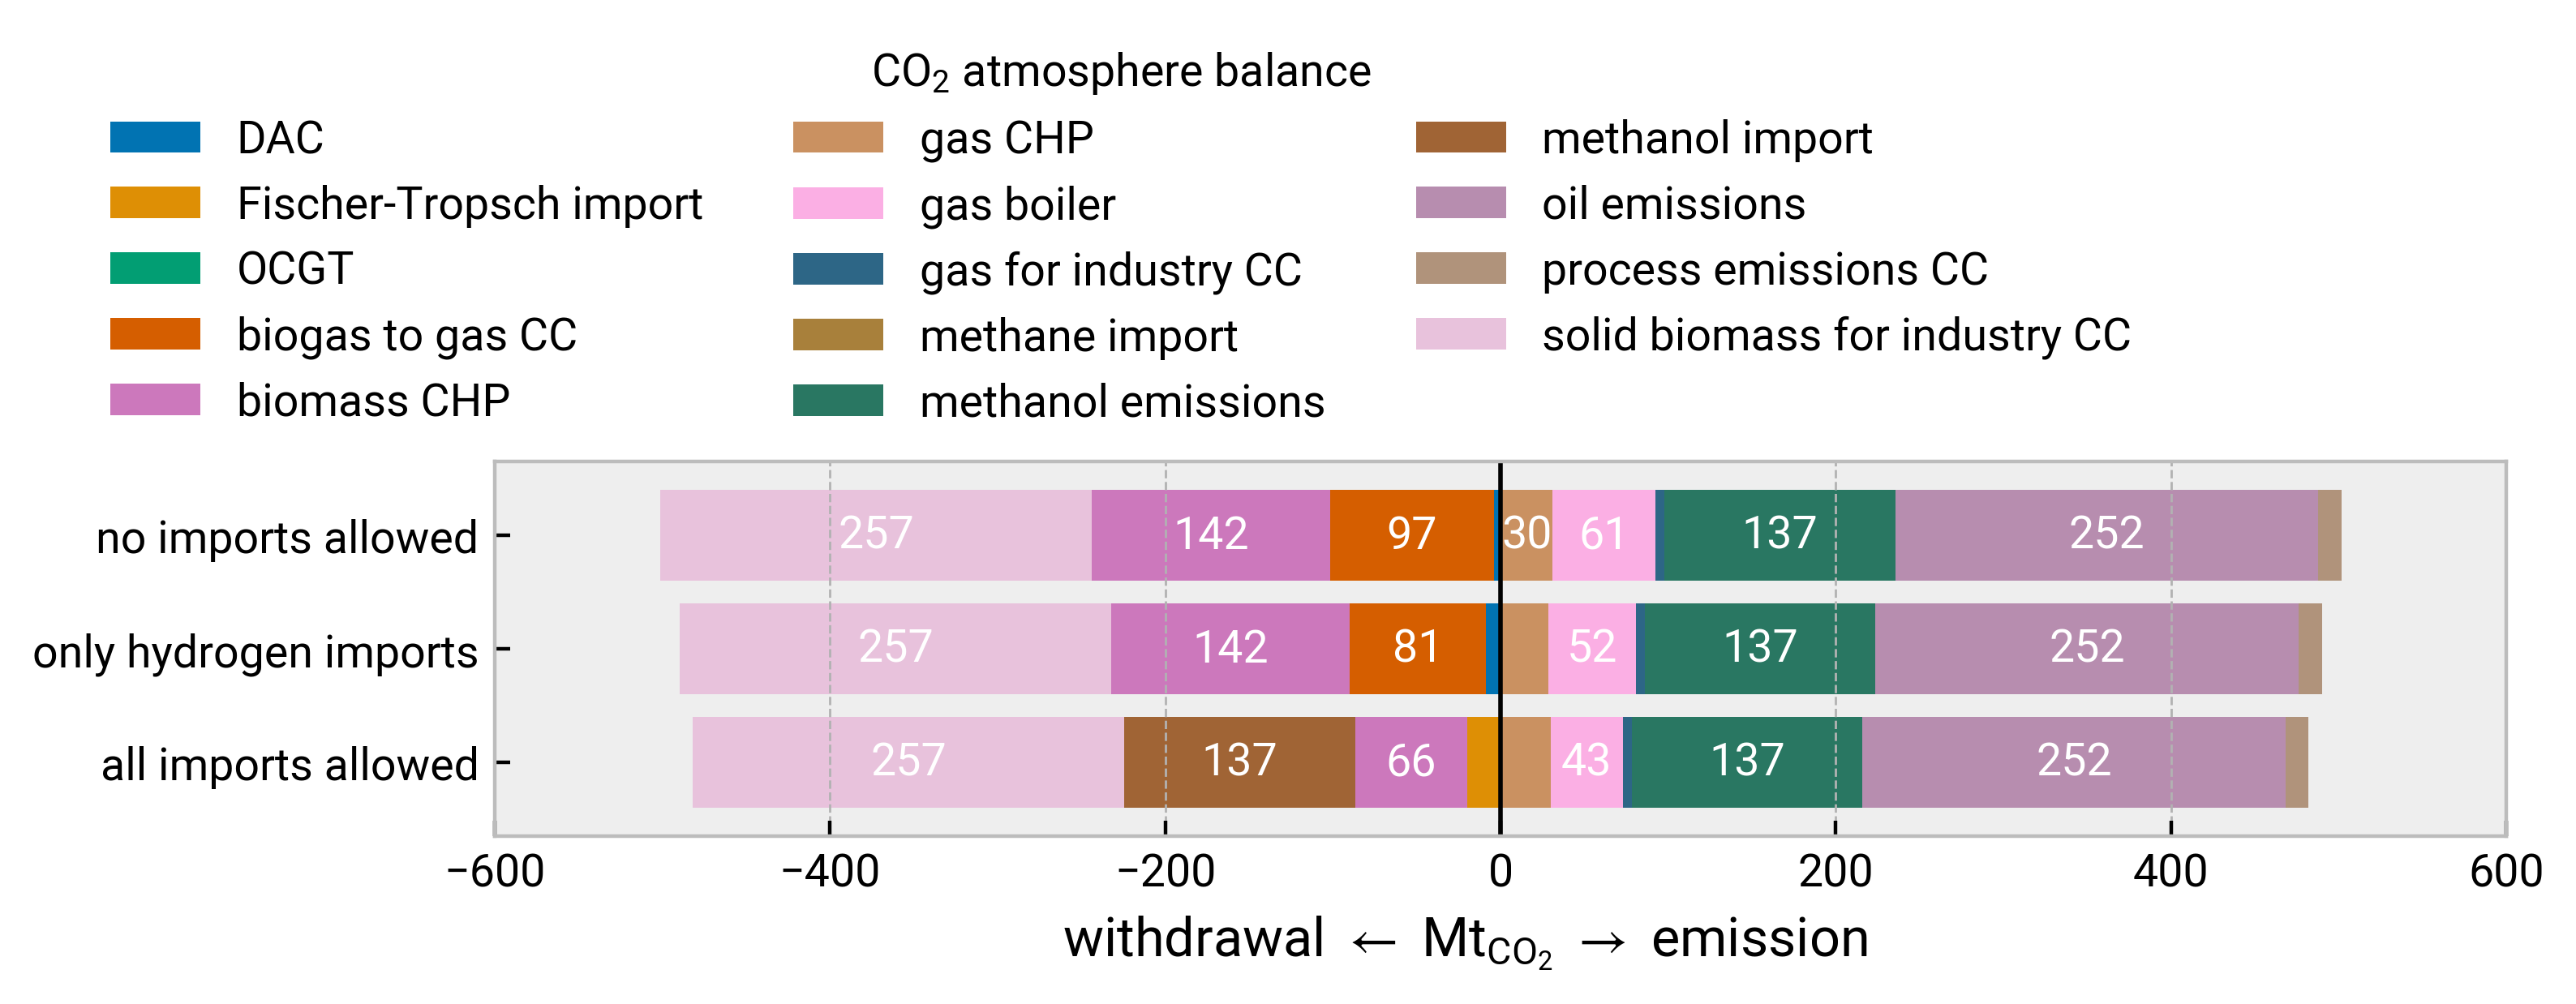

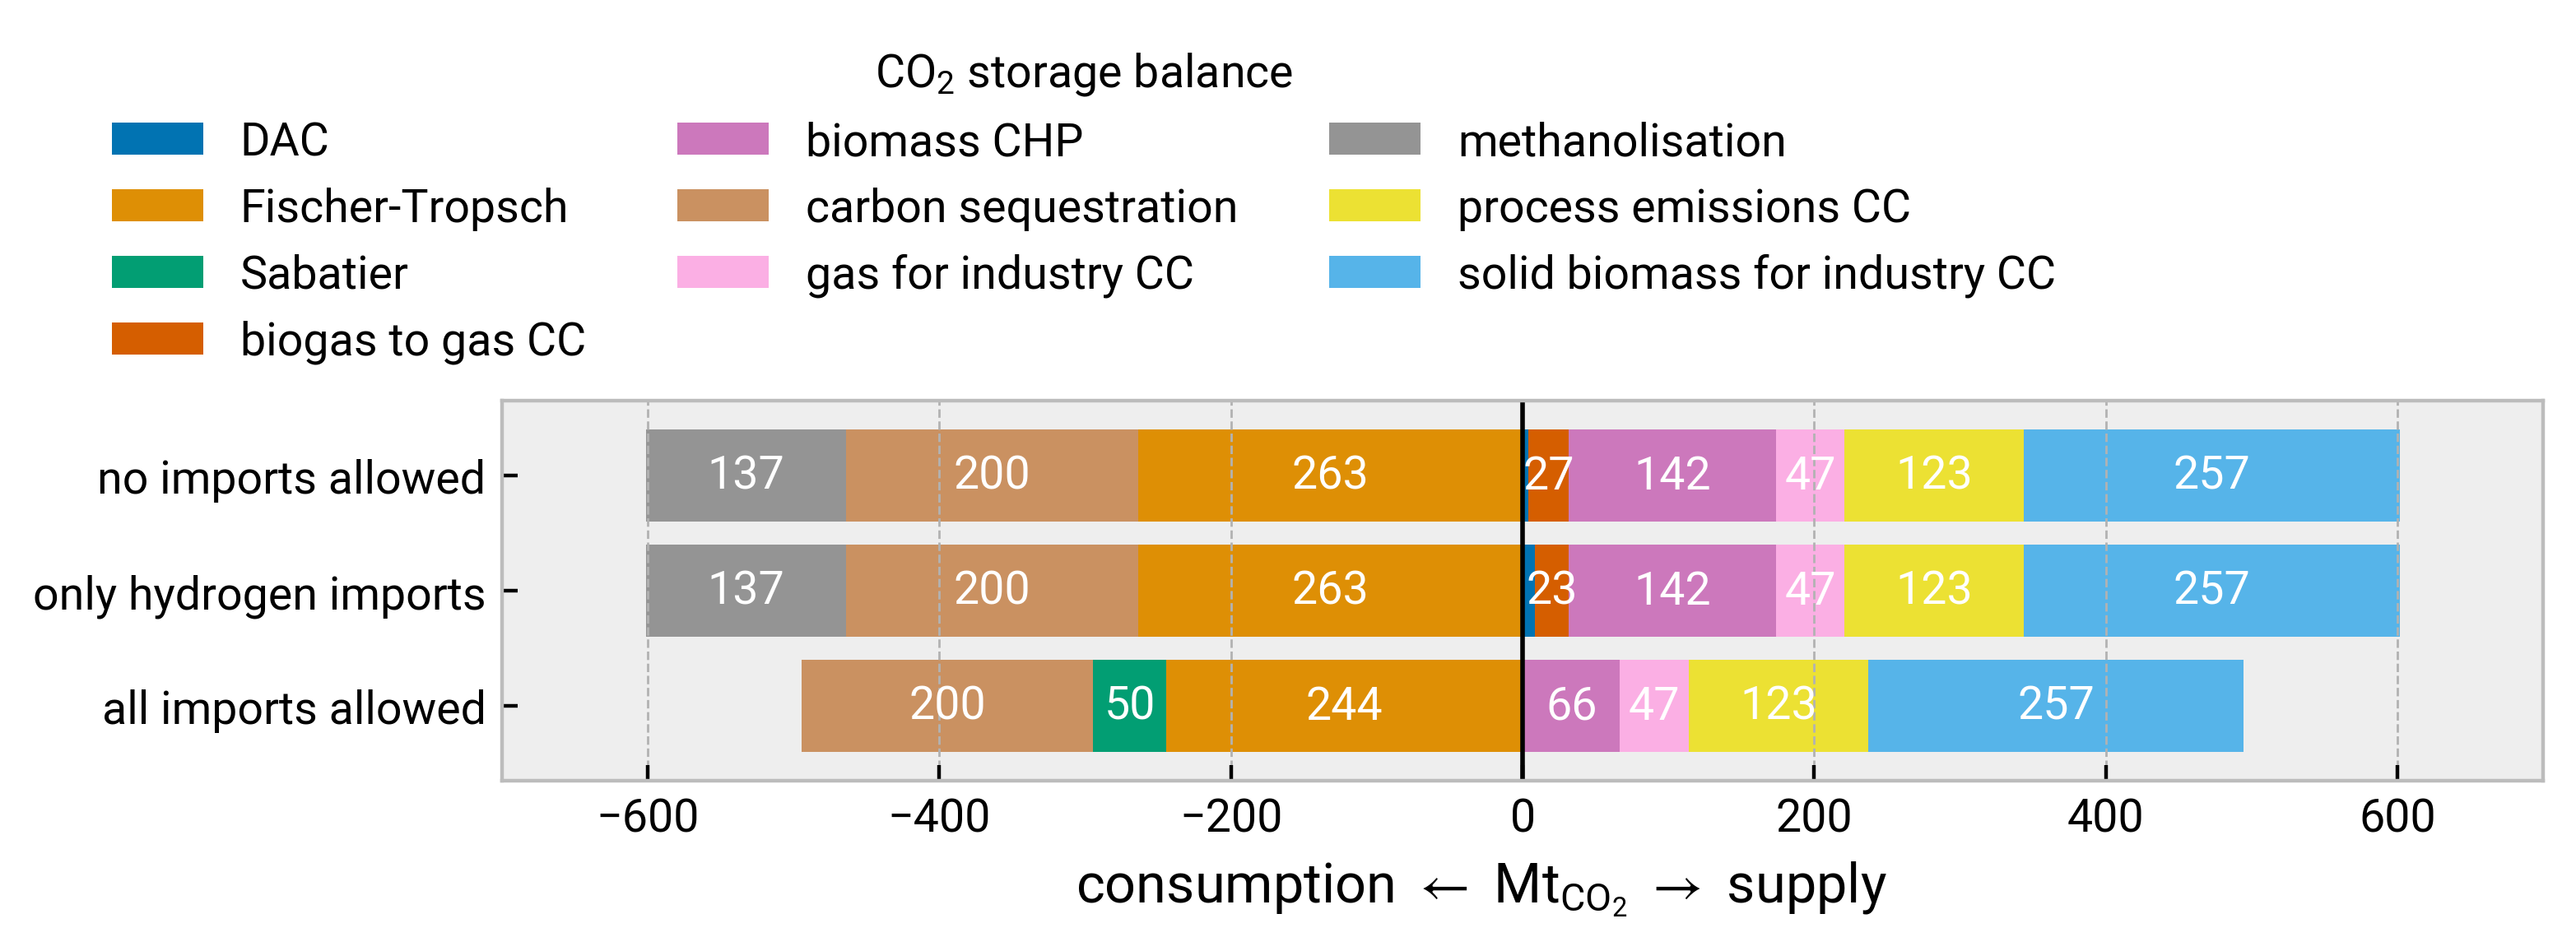

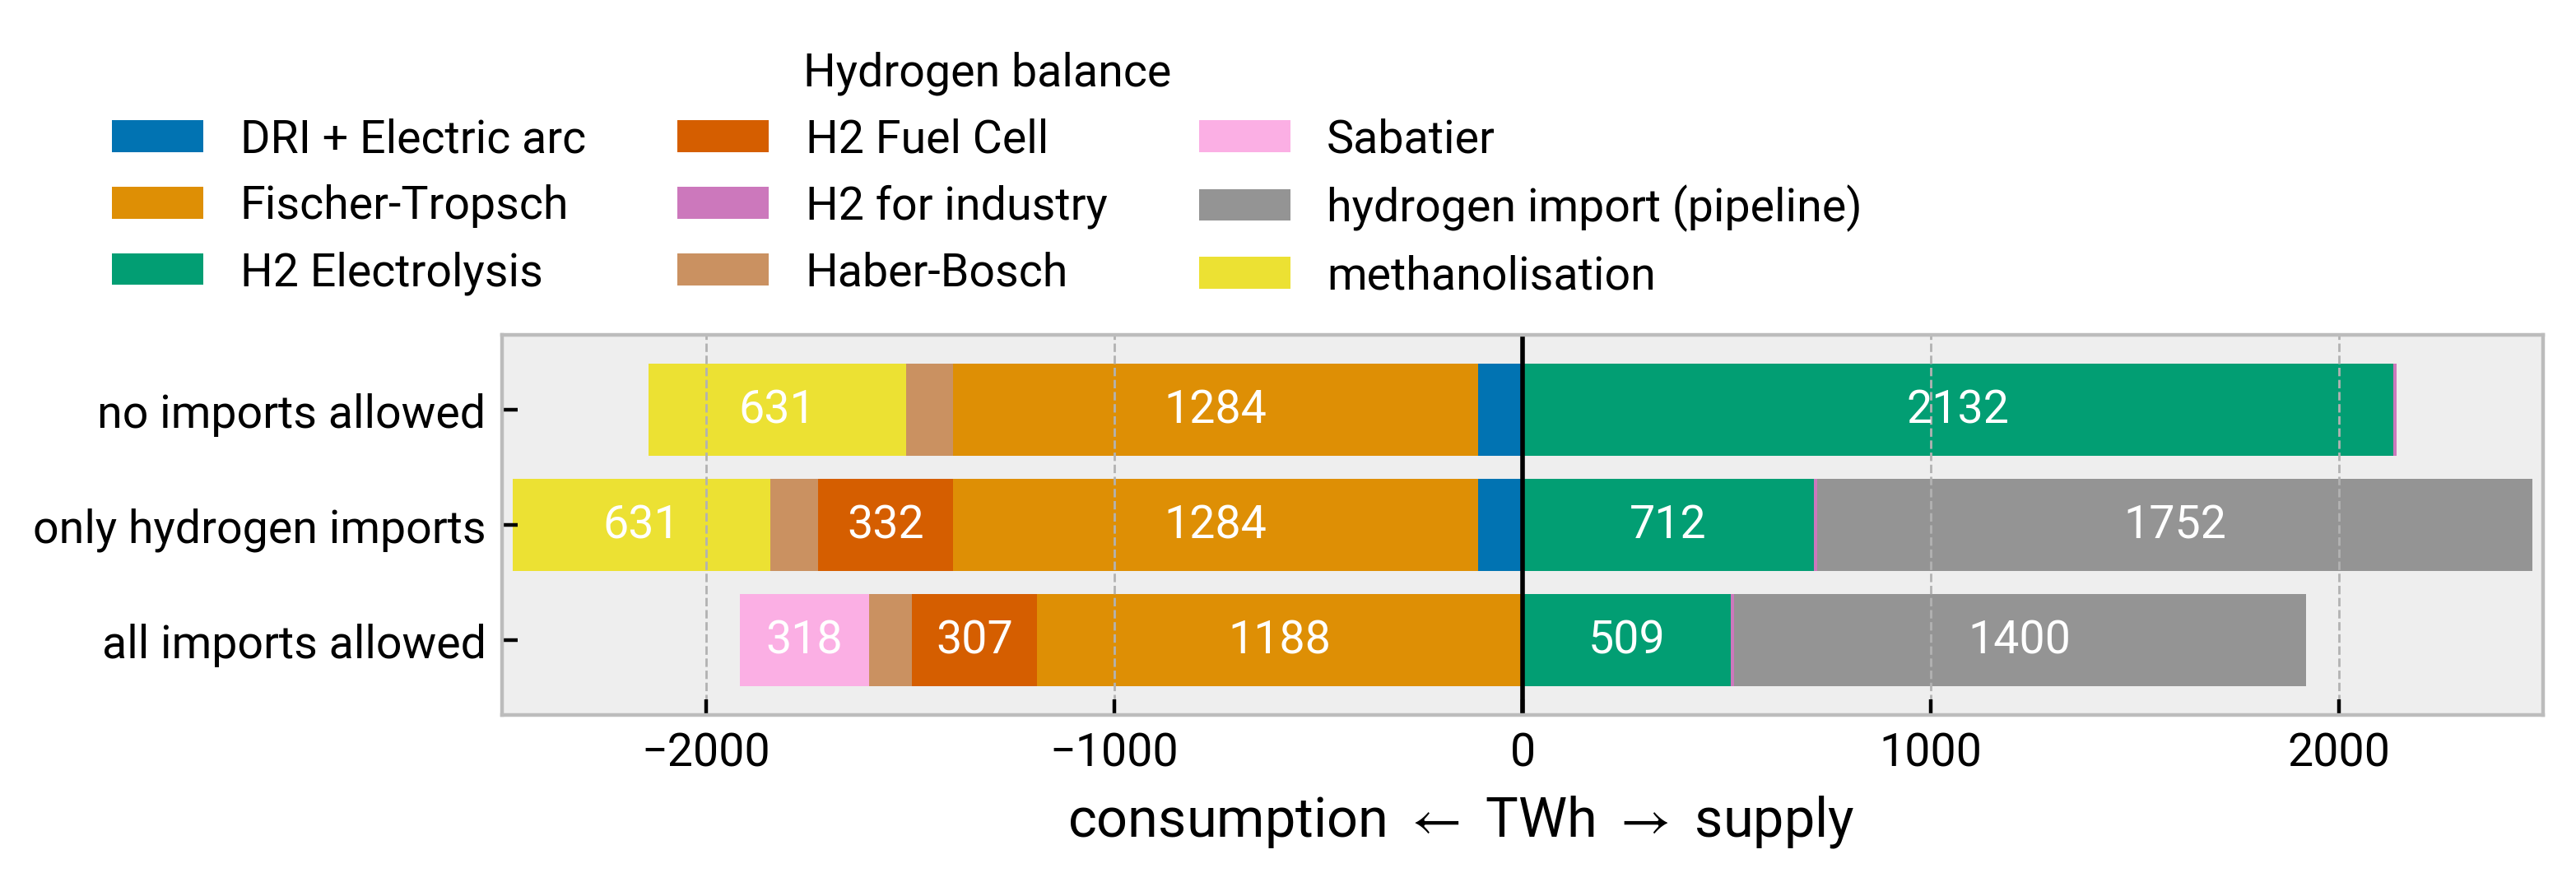

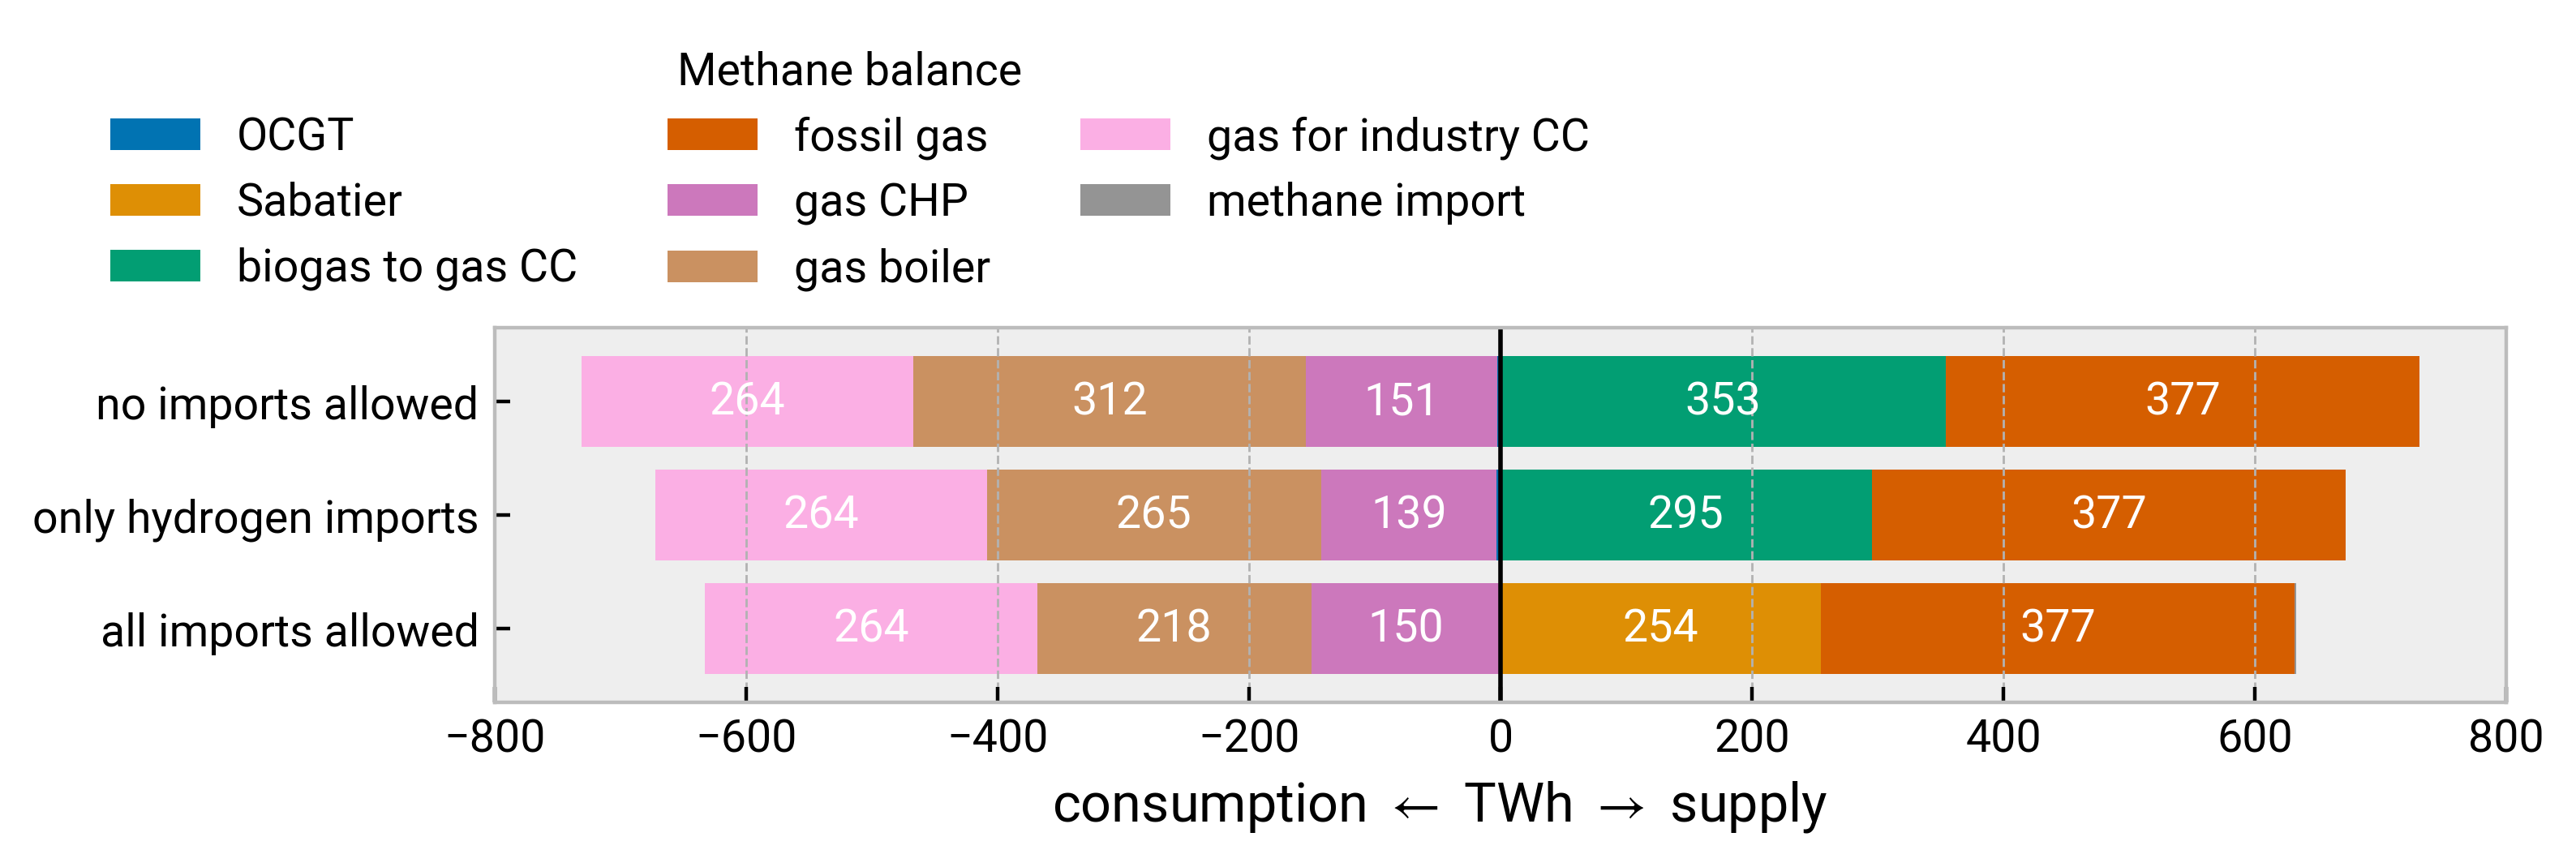

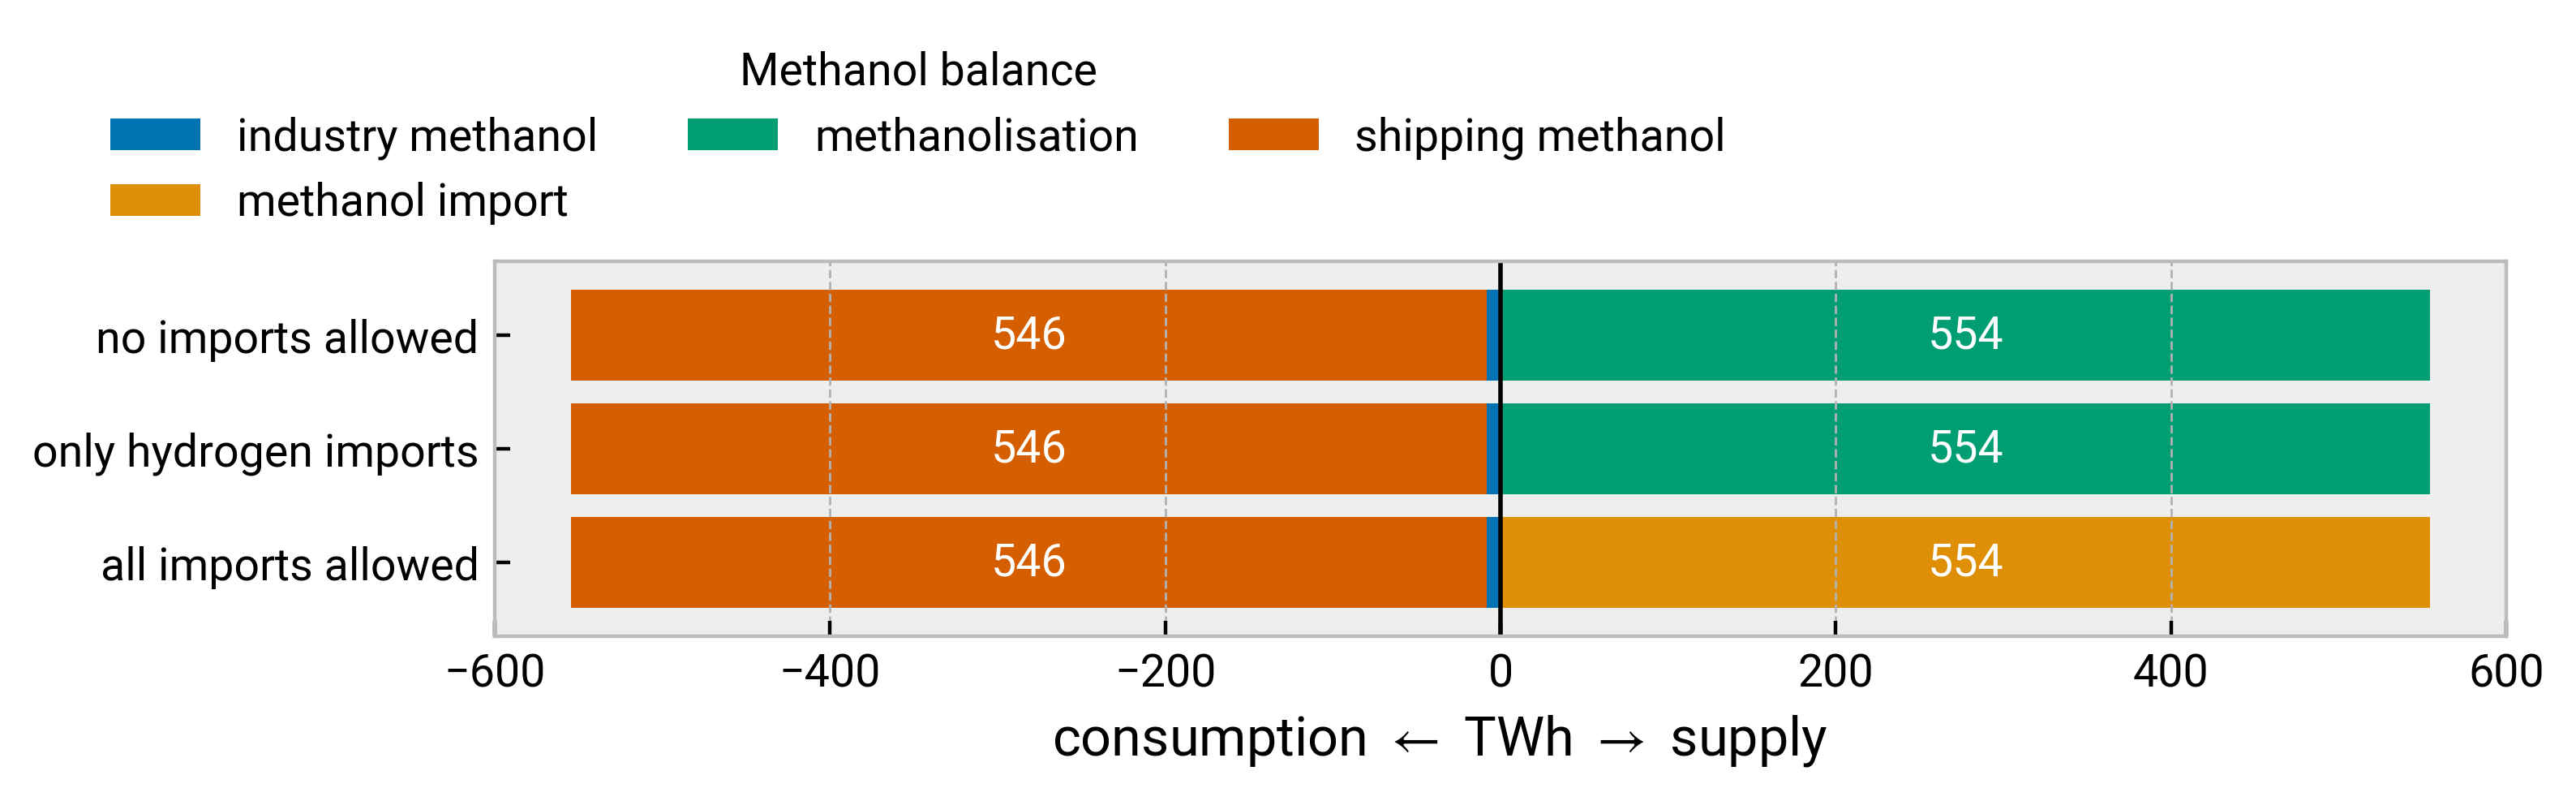

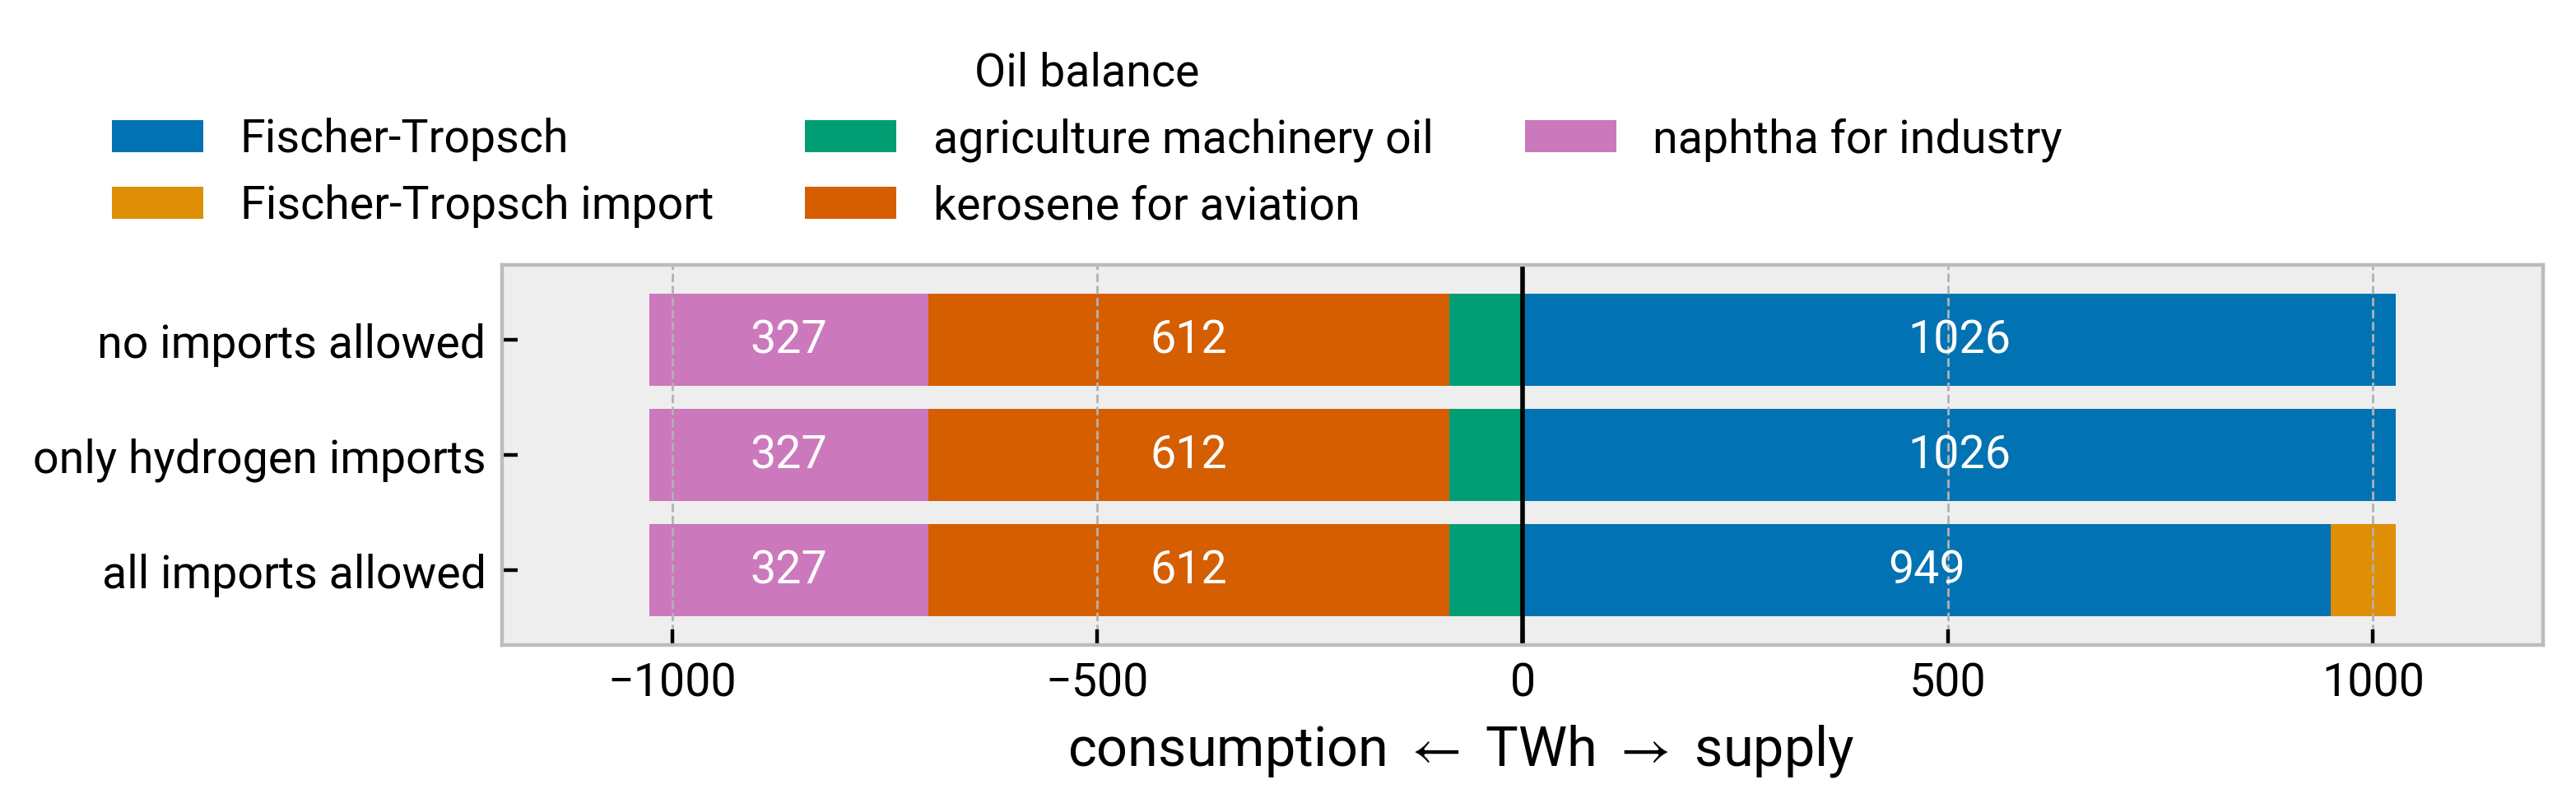

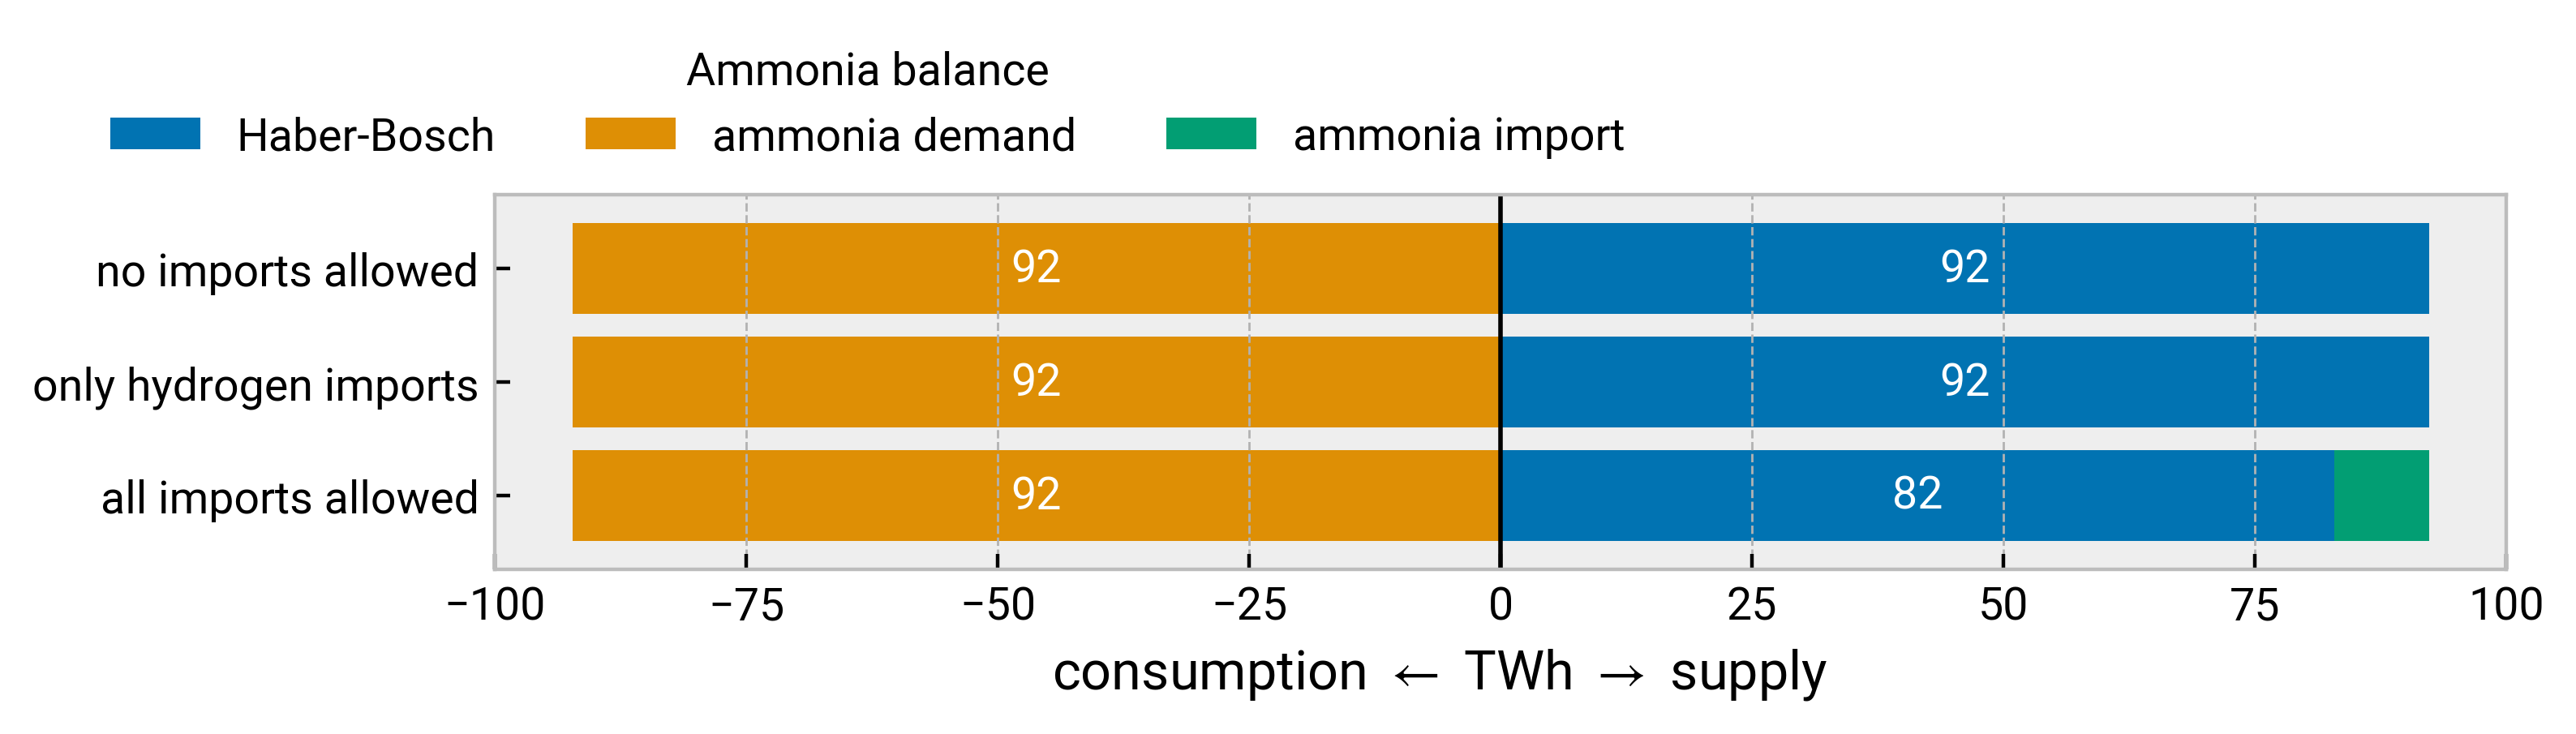

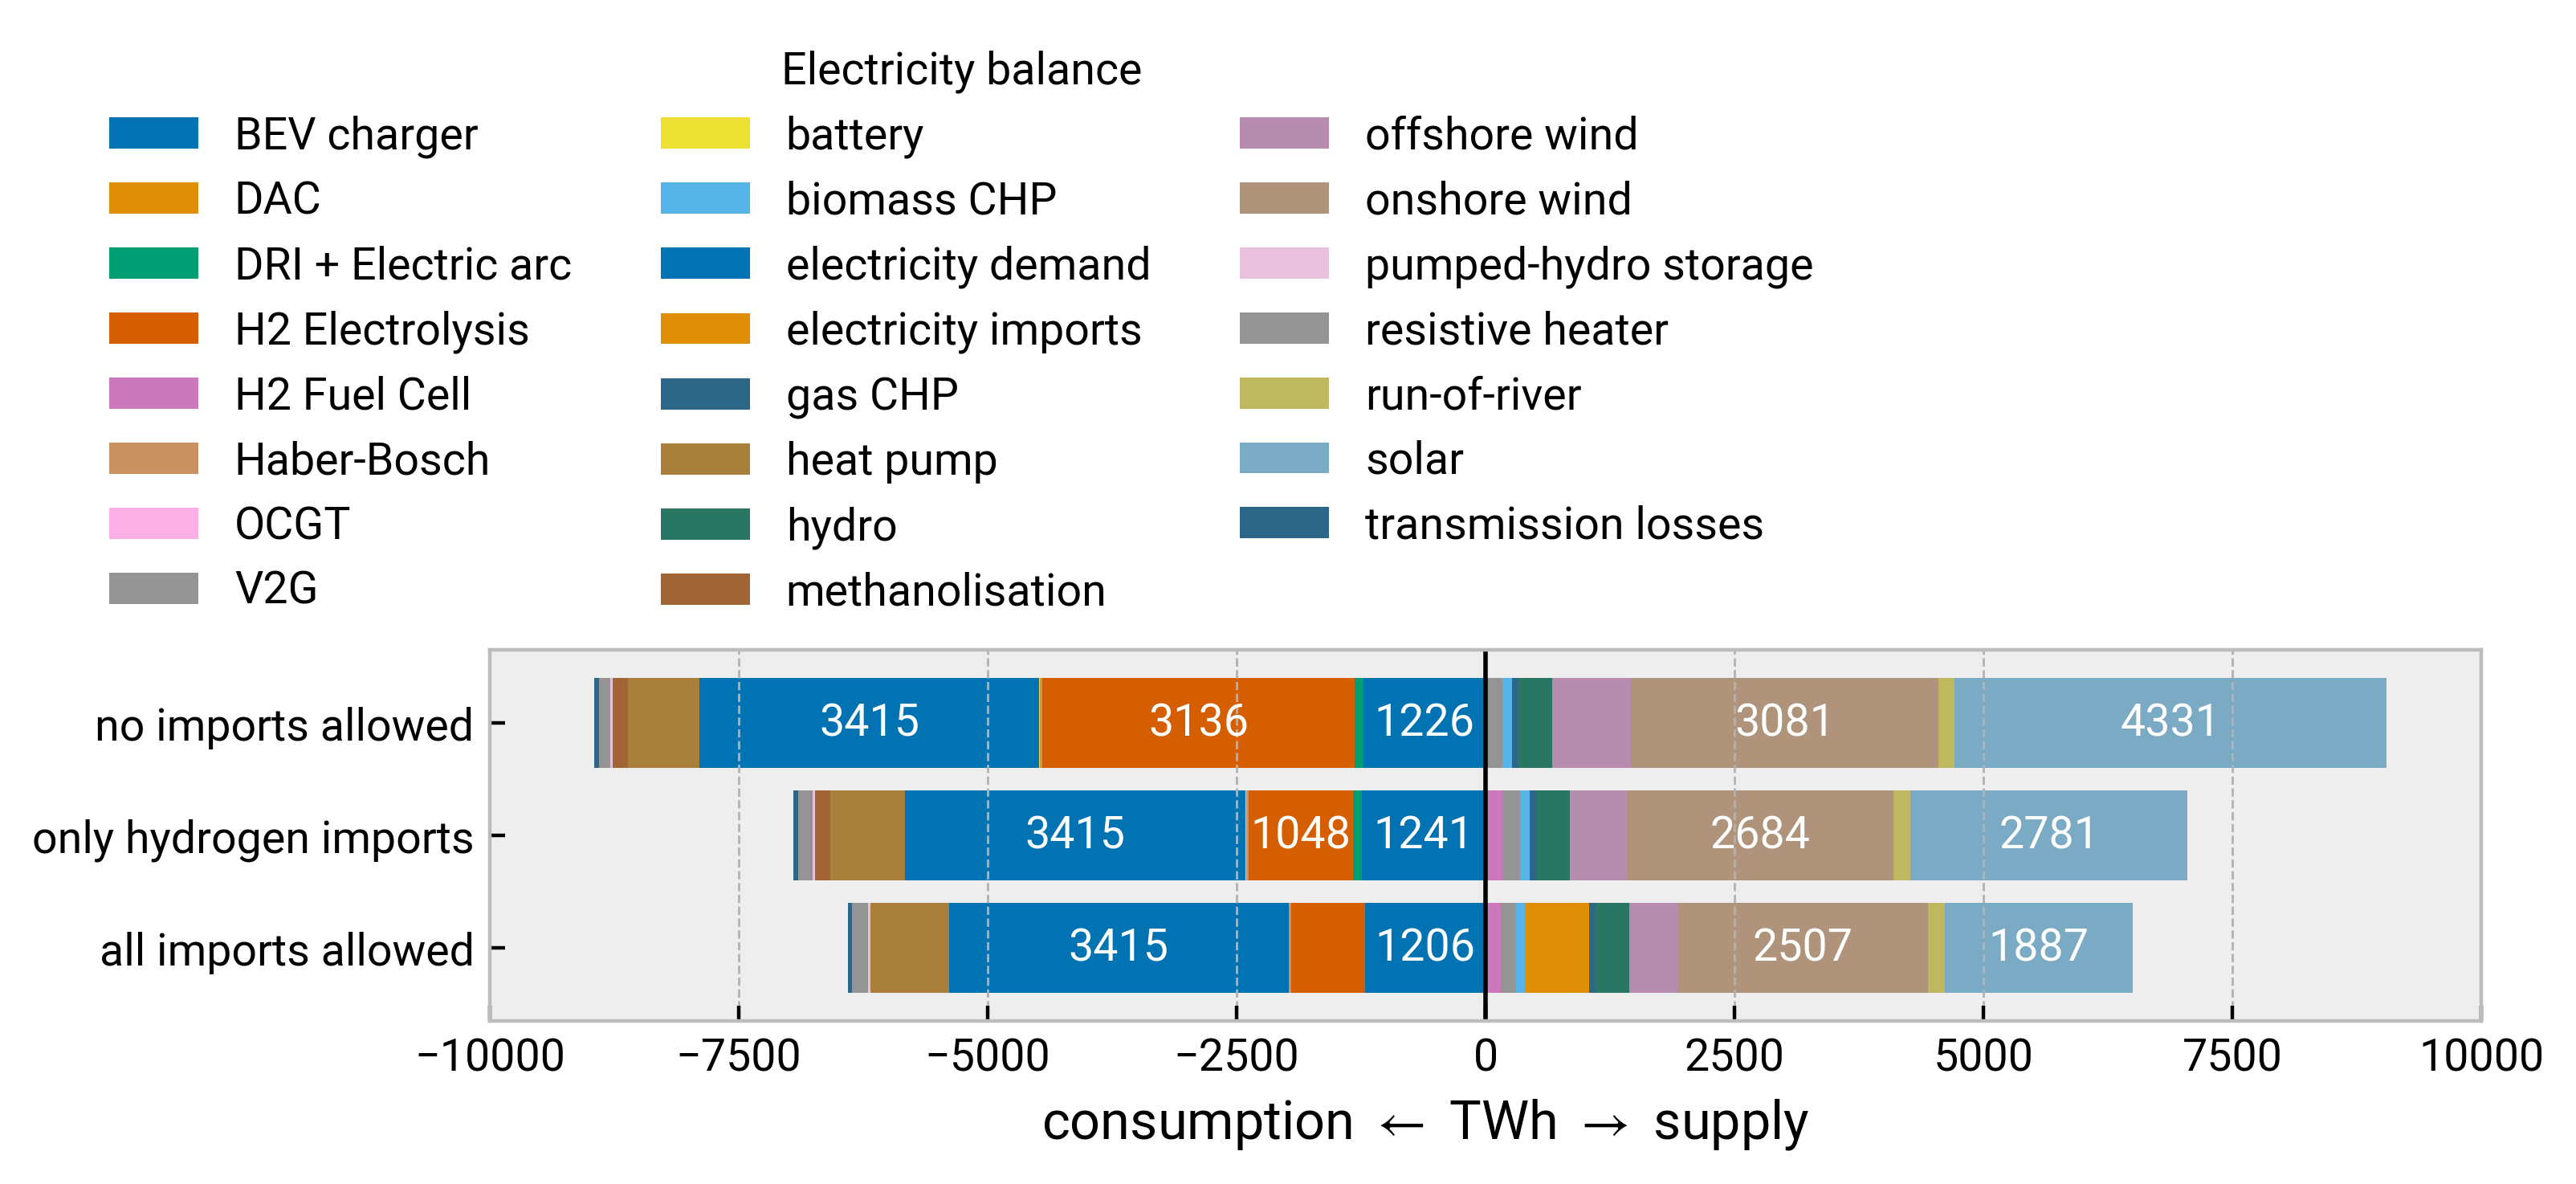

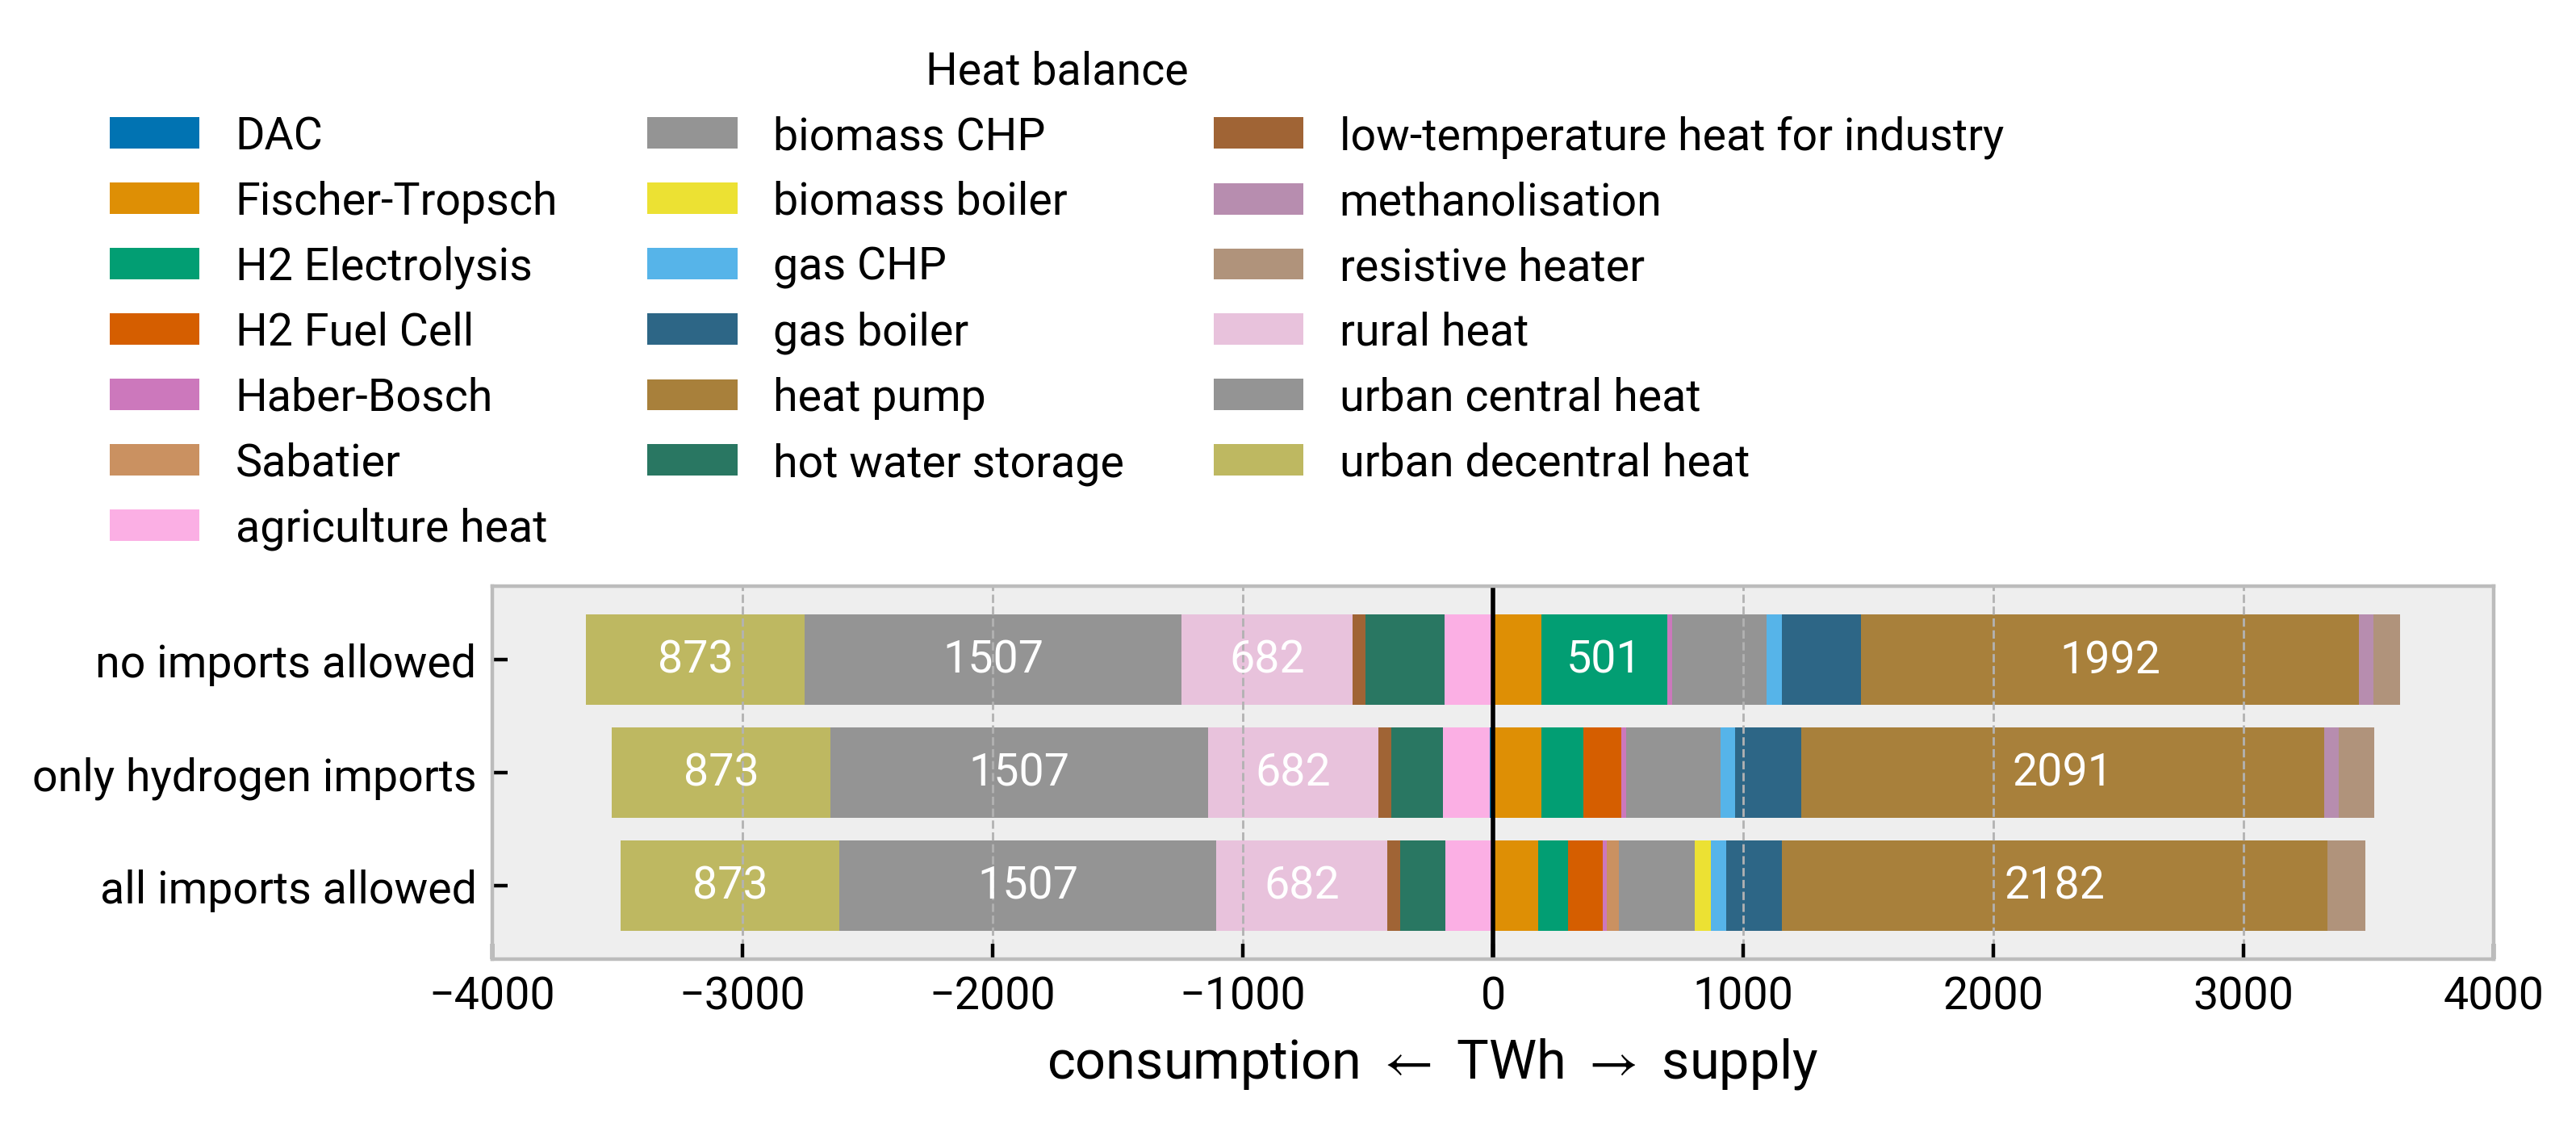

In [187]:
for carrier in carrier_nice_names.keys():
    if carrier == "electricity":
        eb = pd.concat([ebs.xs("AC", level='bus_carrier'), ebs.xs("low voltage", level='bus_carrier')])
        eb = eb.groupby(eb.index).sum()
        eb.index = pd.MultiIndex.from_tuples(eb.index)
        eb.index = eb.index.droplevel(1)
        carrier_balance = eb.unstack(0).dropna(how='all', axis=0)
    elif carrier == "heat":
        eb = pd.concat([
            ebs.xs("urban central heat", level='bus_carrier'),
            ebs.xs("urban decentral heat", level='bus_carrier'),
            ebs.xs("rural heat", level='bus_carrier')
        ])
        eb = eb.groupby(eb.index).sum()
        eb.index = pd.MultiIndex.from_tuples(eb.index)
        eb.index = eb.index.droplevel(1)
        carrier_balance = eb.unstack(0).dropna(how='all', axis=0)
    else:
        carrier_balance = ebs.xs(carrier, level='bus_carrier').unstack(0).dropna(how='all', axis=0)
        carrier_balance.index = carrier_balance.index.droplevel("component")
    carrier_balance = carrier_balance[scenarios_fn.keys()]

    carrier_balance = carrier_balance.groupby(rename, axis=0).sum()

    fig, ax = plt.subplots(figsize=(8, 1.5))

    num_colors = len(carrier_balance.index)
    if num_colors > 10:
        pal = sns.color_palette("colorblind", n_colors=int(np.ceil(num_colors/2))) + sns.color_palette("colorblind", n_colors=int(np.floor(num_colors/2)), desat=0.5)
    else:
        pal = sns.color_palette("colorblind", n_colors=num_colors)

    fig.set_tight_layout(False)

    carrier_balance.T.plot.barh(stacked=True, width=0.8, ax=ax, color=pal)

    for container in ax.containers:
        ax.bar_label(
            container,
            label_type="center",
            color="white",
            fmt=lambda x: np.abs(x.astype(int)) if np.abs(x) > carrier_label_limits.get(carrier, 30) else "",
        )

    ax.axvline(0, color='k', lw=1)

    ax.set_xlabel(carrier_xlabels.get(carrier, ""))

    ax.set_xlim(-carrier_xlims.get(carrier, 100), carrier_xlims.get(carrier, 100))

    plt.grid(axis="y")

    plt.legend(ncol=3, loc=(-0.2,1.05), title=carrier_nice_names.get(carrier, carrier))

    for ext in [".png", ".pdf"]:
        plt.savefig(f"{RUN}/balances-{carrier}{ext}", bbox_inches='tight')

